In [13]:
!pip install kaggle
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

!pip install pydensecrf

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ewopve6v
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ewopve6v
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit dd070546eda51e21ab772ee6f14807c7f5b1548b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405483 sha256=fabb3df571a408a5d6992330ddd9545587bc63e3816fc91bdd01a04e77611eb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnu0xp7x/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [14]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"deepshahane","key":"a4aa769a8e272037589a84602ebce54f"}'}

In [15]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file.  # Change the permissions of the file.

In [16]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset  # Use the correct dataset path
!unzip -q deepglobe-road-extraction-dataset.zip -d dataset-folder

deepglobe-road-extraction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset-folder/class_dict.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Unet Augmentation

In [17]:
# Unet Augmentation
import os
import cv2
import numpy as np
import pickle

# Load the model from the pickle file
with open('/content/drive/MyDrive/Cv_Project/U_net/unet_model_augmentation_model.pkl', 'rb') as file:
    model = pickle.load(file)

test_folder = '/content/dataset-folder/test'  # Specify your test dataset path

test_images = []
test_filenames = []

# Load and preprocess test images
for filename in os.listdir(test_folder):
    if filename.endswith('.jpg'):  # Assuming the images are in '.jpg' format
        img_path = os.path.join(test_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (128, 128))  # Resize to match the model's expected input
        img = img / 255.0  # Normalize the image
        test_images.append(img)
        test_filenames.append(filename)

# Convert the list of images to a numpy array
test_images_np = np.array(test_images)

# Generate predictions
predictions_ua = model.predict(test_images_np)

# Continue with your code to handle predictions...


35/35 [==============================] - 1s 34ms/step


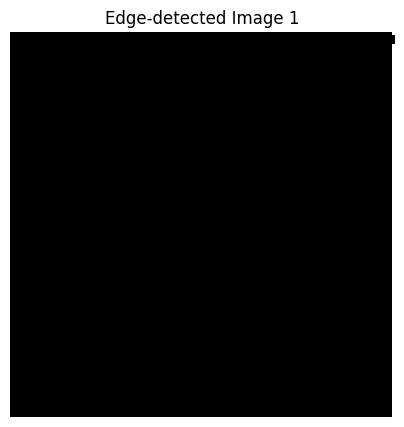

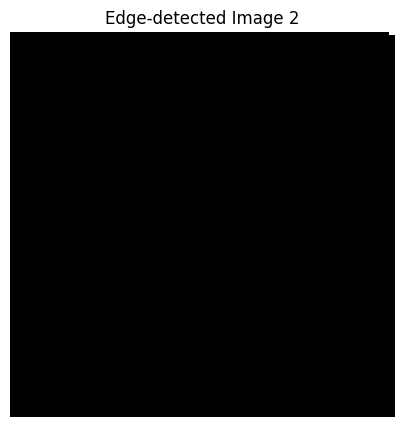

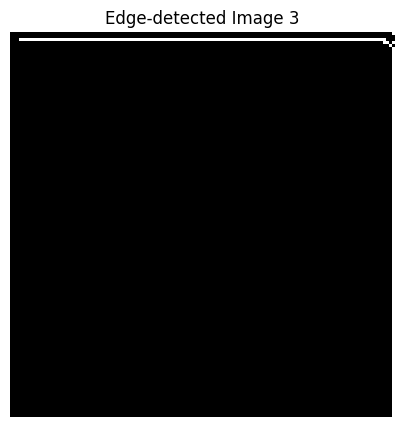

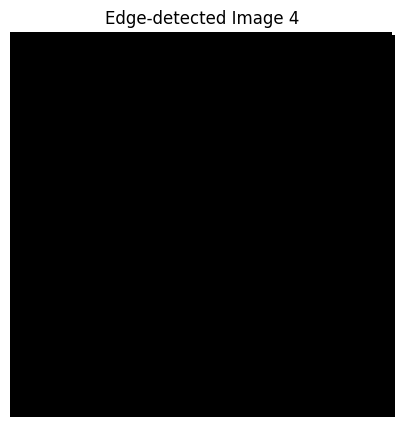

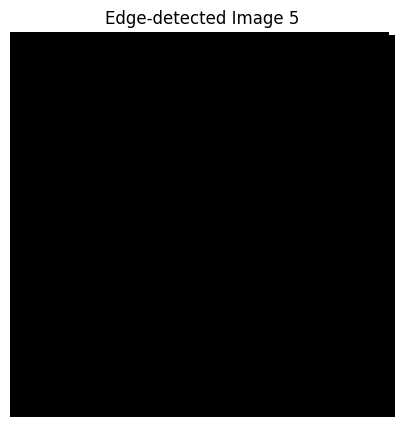

In [18]:
# Unet Augmentation Edge
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to apply edge detection
def apply_edge_detection(image):
    # Convert to grayscale if it is not already
    if image.ndim == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    # Apply edge detection
    edges = cv2.Canny(gray.astype(np.uint8), 100, 200)
    return edges

# Apply edge detection to each prediction and multiply by 255 if they are in [0, 1] range
edge_detected_predictions = np.array([apply_edge_detection(pred * 255) if pred.max() <= 1 else apply_edge_detection(pred) for pred in predictions_ua])

# Now, let's visualize the first few edge-detected images
num_images_to_show = 5  # Set this to the number of images you want to display
for i in range(min(num_images_to_show, len(edge_detected_predictions))):
    plt.figure(figsize=(5, 5))
    plt.imshow(edge_detected_predictions[i], cmap='gray')
    plt.title(f'Edge-detected Image {i+1}')
    plt.axis('off')
    plt.show()


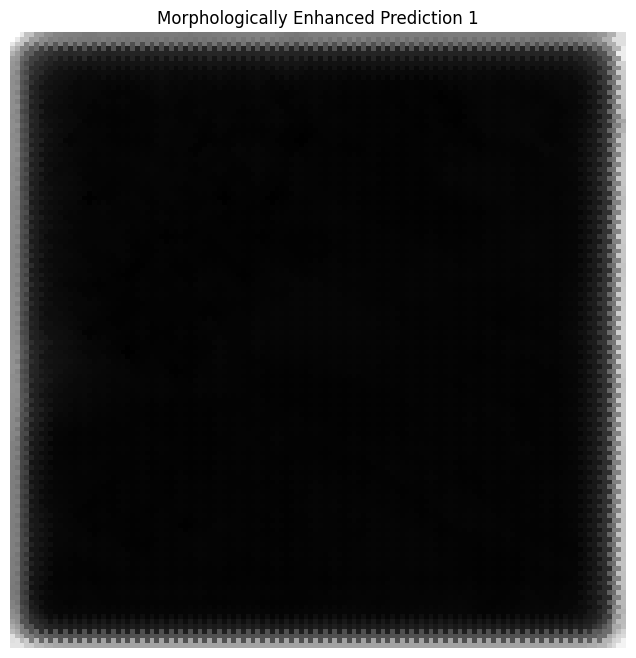

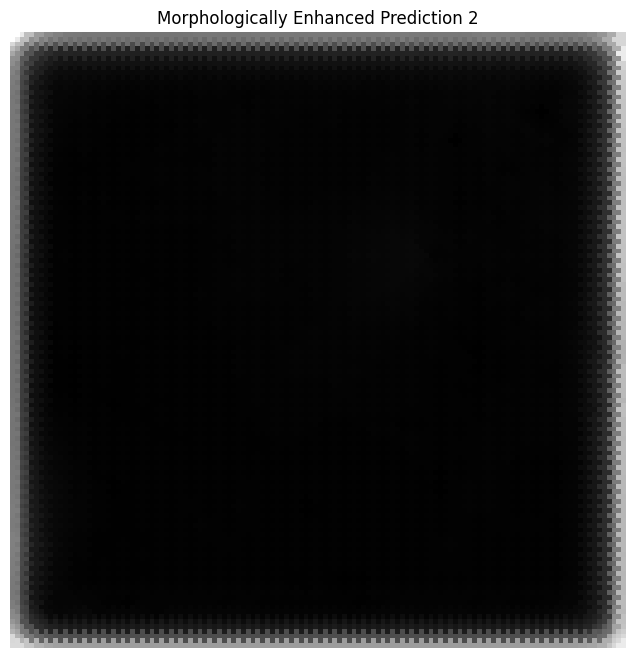

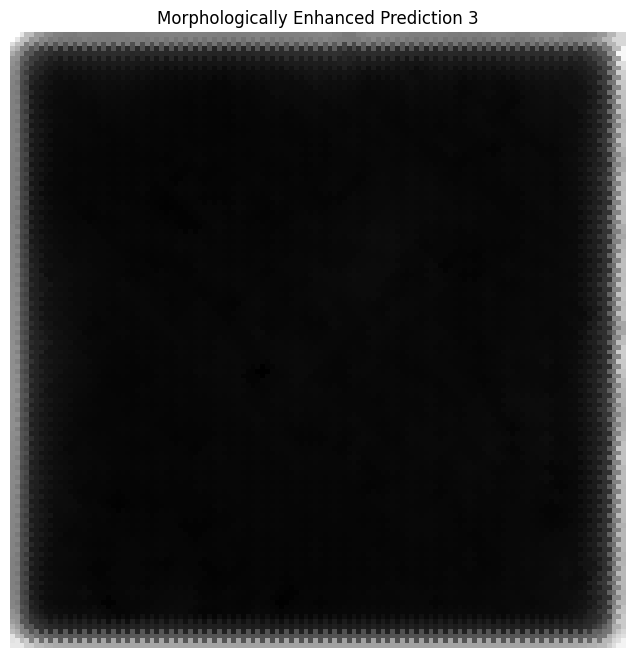

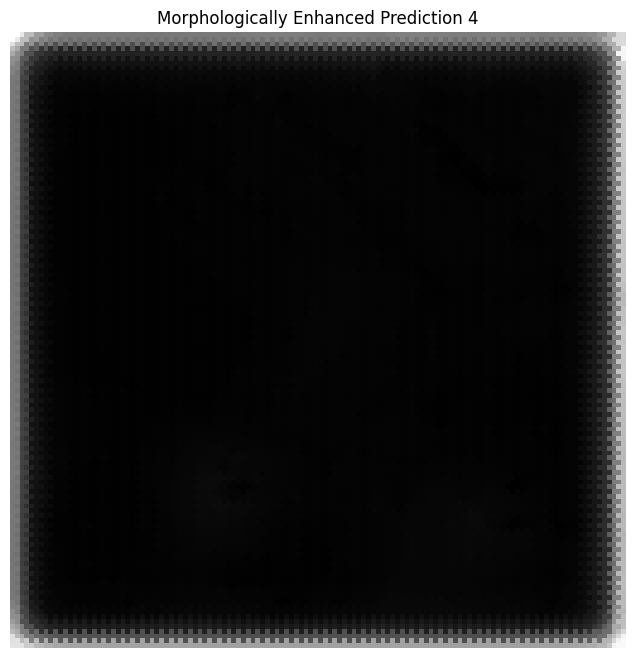

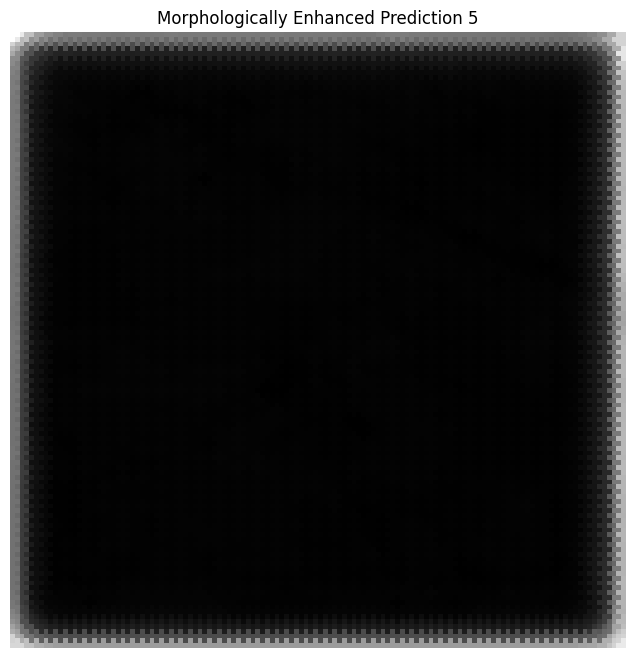

In [19]:
#unet aug morphological operations

#morphological operations
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_morphological_operations(prediction, kernel_size=3):
    """
    Apply morphological operations to enhance the segmentation result.

    :param prediction: The binary prediction image (numpy array).
    :param kernel_size: Size of the structuring element.
    :return: Processed image.
    """
    # Create a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Erosion (removes small objects from the foreground)
    eroded = cv2.erode(prediction, kernel, iterations=1)

    # Dilation (adds pixels to the boundaries of objects in the foreground)
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    # Opening (Erosion followed by dilation, useful for removing noise)
    opened = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)

    # Closing (Dilation followed by erosion, useful for closing small holes)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    return closed

# Assuming 'predictions' is a list of binary segmentation maps
morphological_predictions = []
for pred in predictions_ua:
    # Apply thresholding if your predictions are probability maps
    # pred = (pred > threshold).astype(np.uint8) * 255

    # Apply the morphological operations
    morph_pred = apply_morphological_operations(pred)
    morphological_predictions.append(morph_pred)

# Visualize the first 5 processed predictions
num_images_to_show = 5
for i, morph_pred in enumerate(morphological_predictions[:num_images_to_show]):
    plt.figure(figsize=(8, 8))
    plt.imshow(morph_pred, cmap='gray')
    plt.title(f'Morphologically Enhanced Prediction {i+1}')
    plt.axis('off')
    plt.show()


In [20]:
#Unet CRF


#Unet Image Enhancement

35/35 [==============================] - 1s 34ms/step


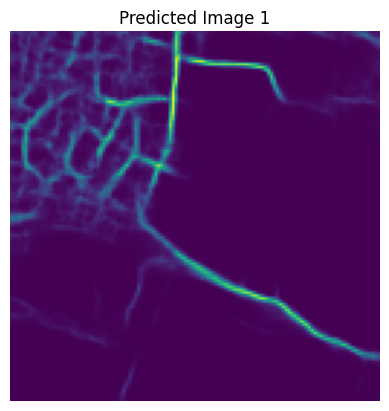

In [21]:
#Unet Model Enhancement
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle

# Define the image enhancement function
def enhance_image(image):
    # Increase contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Adjust the contrast factor as needed

    # Convert to grayscale before equalization
    image = image.convert('L')

    # Apply histogram equalization
    image_eq = cv2.equalizeHist(np.array(image))

    # Convert back to PIL image for further enhancement
    image_eq = Image.fromarray(image_eq)

    # Increase sharpness
    enhancer = ImageEnhance.Sharpness(image_eq)
    image_sharpened = enhancer.enhance(2.0)  # Adjust the sharpness factor as needed

    return image_sharpened

# Load, enhance, and preprocess test images
test_folder = '/content/dataset-folder/test'  # Specify your test dataset path
test_images = []

for filename in os.listdir(test_folder):
    if filename.endswith('.jpg'):  # Adjust this as per your file format
        img_path = os.path.join(test_folder, filename)
        img = Image.open(img_path)
        img_enhanced = enhance_image(img)
        img_enhanced = img_enhanced.resize((128, 128))  # Resize to model's expected input size
        img_array = np.array(img_enhanced)

        # If the model expects color images, duplicate the grayscale channel across 3 channels
        img_array = np.stack((img_array,) * 3, axis=-1)  # Duplicate the single channel to get a 3-channel image

        img_array = img_array / 255.0  # Normalize
        test_images.append(img_array)

# Convert the list of images to a numpy array
test_images_np = np.array(test_images)

# Load the model from the pickle file
with open('/content/drive/MyDrive/Cv_Project/U_net/unet_model_enhancement_file.pkl', 'rb') as file:
    model = pickle.load(file)

# Generate predictions
predictions_ue = model.predict(test_images_np)

plt.imshow(predictions_ue[0].squeeze(), cmap='gray' if predictions_ue[0].ndim == 2 else None)
plt.title('Predicted Image 1')
plt.axis('off')  # Hide the axis
plt.show()

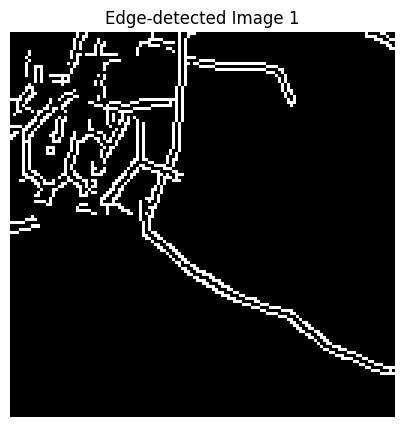

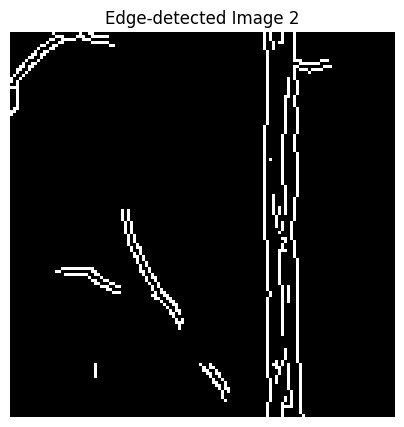

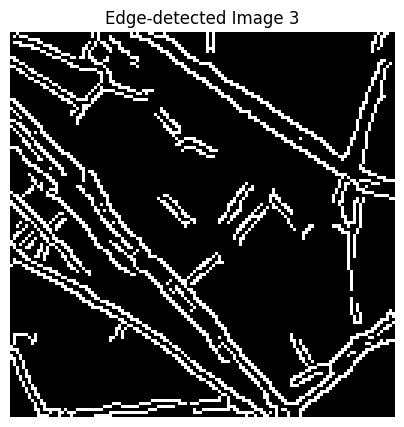

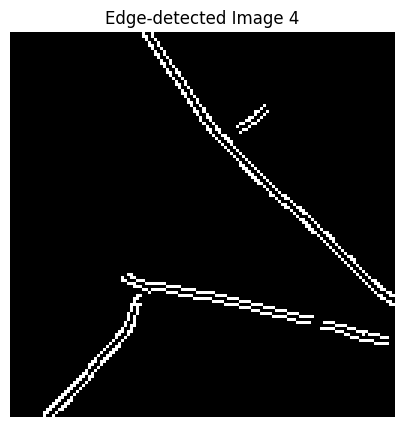

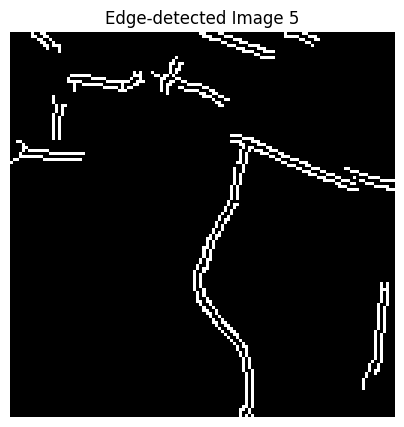

In [22]:
# edge on enhancement
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to apply edge detection
def apply_edge_detection(image):
    # Convert to grayscale if it is not already
    if image.ndim == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    # Apply edge detection
    edges = cv2.Canny(gray.astype(np.uint8), 100, 200)
    return edges

# Apply edge detection to each prediction and multiply by 255 if they are in [0, 1] range
edge_detected_predictions = np.array([apply_edge_detection(pred * 255) if pred.max() <= 1 else apply_edge_detection(pred) for pred in predictions_ue])

# Now, let's visualize the first few edge-detected images
num_images_to_show = 5  # Set this to the number of images you want to display
for i in range(min(num_images_to_show, len(edge_detected_predictions))):
    plt.figure(figsize=(5, 5))
    plt.imshow(edge_detected_predictions[i], cmap='gray')
    plt.title(f'Edge-detected Image {i+1}')
    plt.axis('off')
    plt.show()


In [23]:
# Morphological


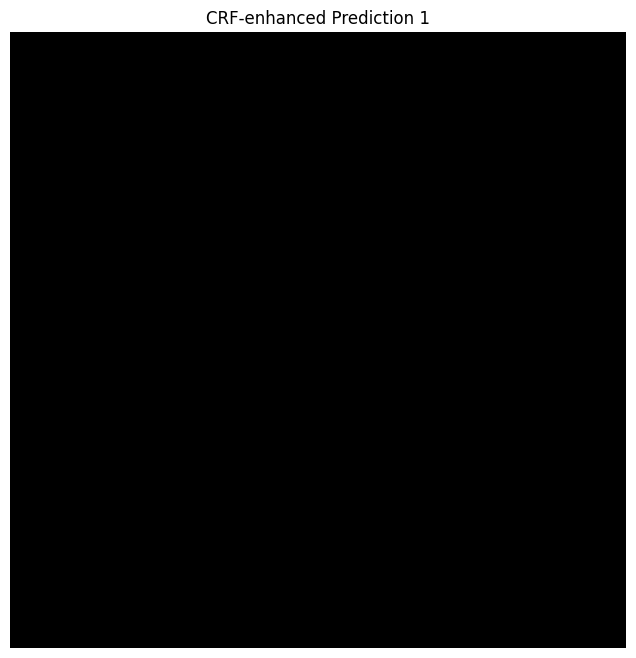

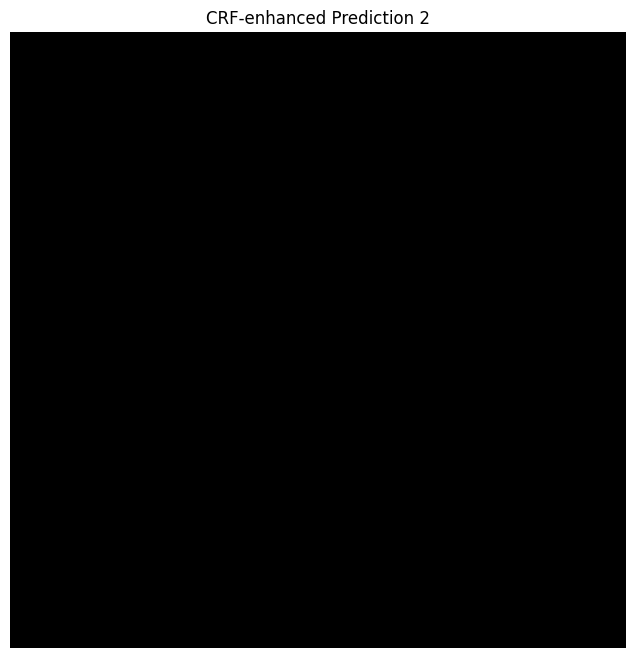

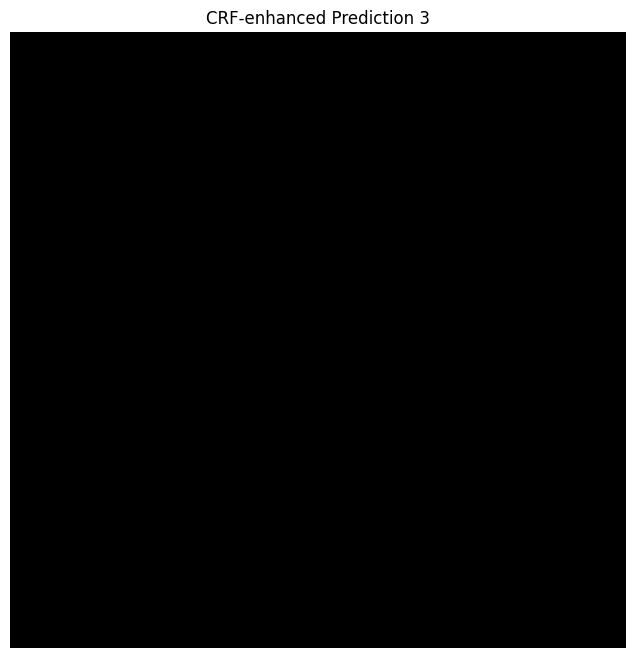

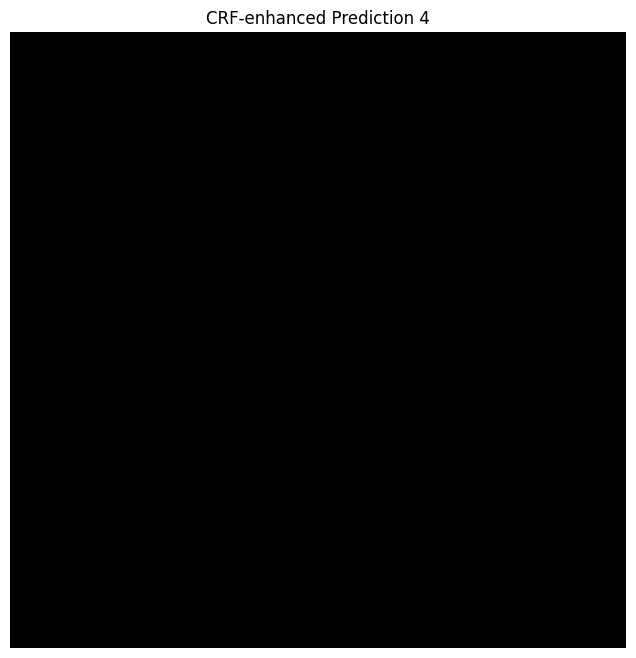

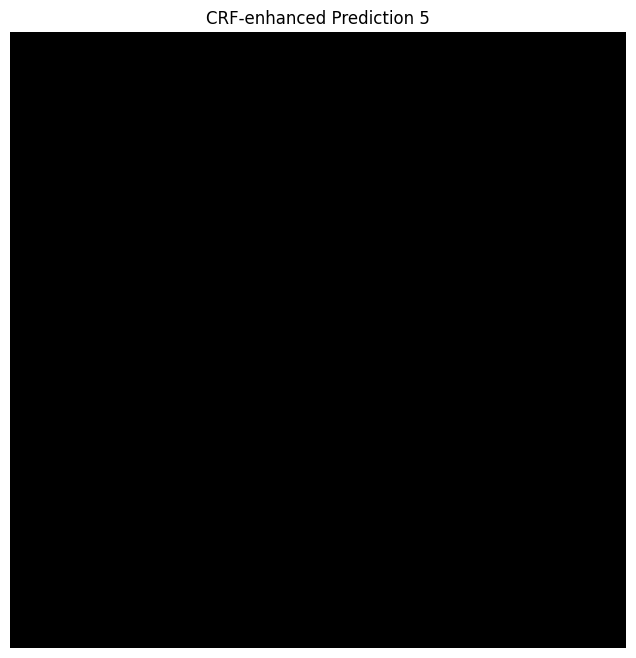

In [24]:
# CRF on enhancement
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
import numpy as np
import os
from PIL import Image

# Function to apply CRF on the prediction
def apply_crf(image, prediction_probabilities, gt_prob=0.7):
    """
    Apply CRF on the prediction probabilities to refine the segmentation.

    :param image: (H, W, 3) [0, 255] RGB image.
    :param prediction_probabilities: (H, W, K) array of probabilities for K classes.
    :param gt_prob: The probability for the ground truth class in the unary potential.
    :return: Refined segmentation.
    """
    n_classes = 2  # Set this to the number of classes in your predictions
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], n_classes)
    unary = unary_from_labels(np.argmax(prediction_probabilities, axis=2).astype(np.uint32), n_classes, gt_prob=gt_prob, zero_unsure=False)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=(3, 3), compat=3)
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=image.astype(np.uint8), compat=10)
    Q = d.inference(5)
    MAP = np.argmax(Q, axis=0)
    return MAP.reshape((image.shape[0], image.shape[1]))

# Load original test images
test_folder = '/content/dataset-folder/test'
original_images = []

for filename in sorted(os.listdir(test_folder)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(test_folder, filename)
        img = Image.open(img_path)
        img = img.resize((128, 128))
        original_images.append(np.array(img))

original_images = np.array(original_images)

# Assuming 'predictions_fe' contains your model's predictions
crf_predictions = []
for i in range(len(predictions_ue)):
    crf_prediction = apply_crf(original_images[i], predictions_ue[i])
    crf_predictions.append(crf_prediction)

# Visualize the first 5 CRF predictions
num_images_to_show = 5
for i, crf_pred in enumerate(crf_predictions[:num_images_to_show]):
    plt.figure(figsize=(8, 8))
    plt.imshow(crf_pred, cmap='gray')
    plt.title(f'CRF-enhanced Prediction {i+1}')
    plt.axis('off')
    plt.show()


#Unet Segmentaiton

In [25]:
# Main code

In [26]:
# Edge

In [27]:
# Morphological

In [28]:
# CRF

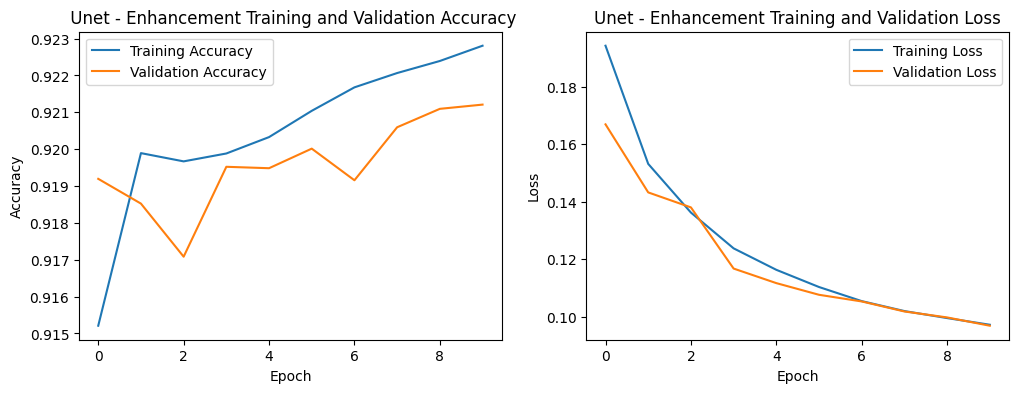

In [29]:
#unet enhancement print
import pickle
import matplotlib.pyplot as plt

# Load the history object from the pickle file
# Make sure to provide the correct path to the history pickle file, not the model file
with open('/content/drive/MyDrive/Cv_Project/U_net/unet_model_enhancment_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title(' Unet - Enhancement Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Unet - Enhancement Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


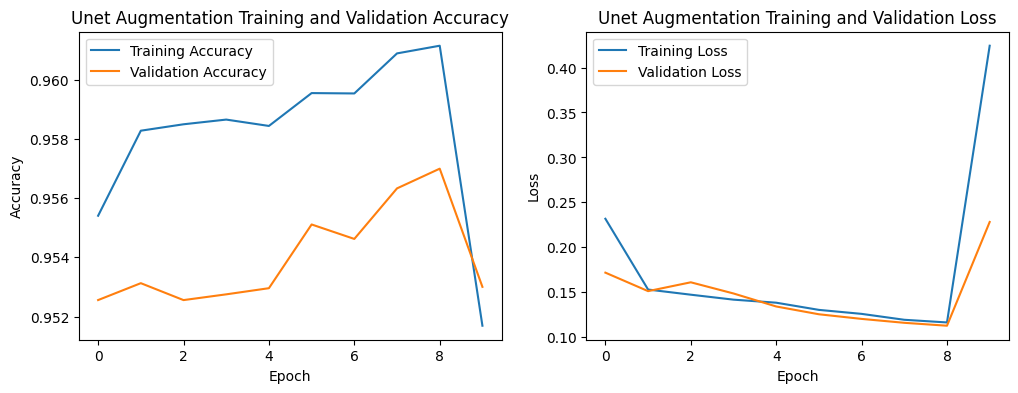

In [30]:
# Unet augmentation print
import pickle
import matplotlib.pyplot as plt

# Load the history object from the pickle file
# Make sure to provide the correct path to the history pickle file, not the model file
with open('/content/drive/MyDrive/Cv_Project/U_net/unet_model_augmentation_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Unet Augmentation Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Unet Augmentation Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


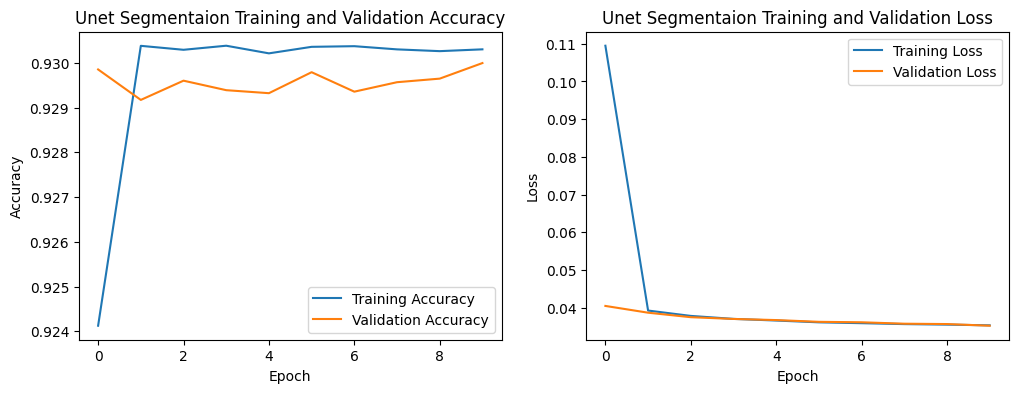

In [31]:
# Unet Segmentaion print
import pickle
import matplotlib.pyplot as plt

# Load the history object from the pickle file
# Make sure to provide the correct path to the history pickle file, not the model file
with open('/content/drive/MyDrive/Cv_Project/U_net/unet_model_segmentation_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Unet Segmentaion Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Unet Segmentaion Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
